<a href="https://colab.research.google.com/github/vsnupoudel/RandomAssignments/blob/main/LfTask_EDAandDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using TFDV, Keras Tuner for quick visualization, Tuning DNN
- Installation wll take upto 2 minutes, uncomment only on first run
- Make sure to restart runtime after running the pip commands.

In [ ]:
# !pip install tensorflow_data_validation
# !pip install apache-beam[interactive]
# !pip install keras-tuner --upgrade

In [ ]:
import numpy as np
import pandas as pd
import random

## Save files in this folder

In [ ]:
!mkdir -p '/content/data/'
%cd /content/data/

/content/data


## To upload the training.csv and validation.csv that was provided

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
train= pd.read_csv('/content/data/training.csv', delimiter=';', decimal=',')
test= pd.read_csv('/content/data/validation.csv', delimiter=';', decimal=',')
# random.seed(12)
train.sample(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
1510,b,19.17,0.000000,y,-4.131223,0.721863,0.00,f,f,0,t,s,500.0,1,5000000.0,NaN,1,yes.
280,b,44.25,0.000050,u,-0.980555,0.646499,10.75,t,f,0,f,s,400.0,0,4000000.0,f,0,no.
547,a,28.67,0.000104,u,-2.877223,0.722623,2.50,t,t,5,t,g,300.0,1430,3000000.0,NaN,1,yes.


In [ ]:
test.sample(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
2,b,36.42,0.000075,y,2.232226,0.627476,0.585,f,f,0,f,g,240.0,3,2400000.0,NaN,1,no.
55,b,25.33,0.000058,u,2.166554,0.578053,0.290,t,t,7,t,g,96.0,5124,960000.0,NaN,0,yes.
85,b,NaN,0.000037,u,-1.677221,0.770857,0.875,t,f,0,t,s,928.0,0,9280000.0,f,0,no.


In [ ]:
train.to_csv('/content/data/train.csv', index= False)
test.to_csv('/content/data/test.csv', index= False)


# Extending pandas dataframe, to display statistics

In [ ]:
import pandas as pd
class HLSpd():
  def __init__(self, csvInput):
    self.df = pd.read_csv(csvInput)
      
  def print_stats_numeric(self):
      return self.df.describe(include= np.number).transpose() #.to_json
      
  def print_stats_object(self):
      return self.df.describe(include= np.object).transpose()

In [ ]:
tt = HLSpd('/content/data/train.csv')

In [ ]:
tt.print_stats_numeric()

,count,mean,std,min,25%,50%,75%,max
v2,3661.0,3.282071e+01,1.266618e+01,13.750000,23.000000,2.867000e+01,4.083000e+01,8.025000e+01
v3,3700.0,5.847872e-04,5.402007e-04,0.000000,0.000150,4.250000e-04,9.625000e-04,2.800000e-03
v5,3700.0,-5.331808e-02,2.871240e+00,-4.996939,-2.516349,-5.278621e-02,2.406251e+00,4.999274e+00
v6,3700.0,7.841879e-01,1.365138e-01,0.273945,0.693130,7.878424e-01,8.760522e-01,1.215066e+00
v7,3700.0,3.439496e+00,4.335229e+00,0.000000,0.500000,1.750000e+00,5.000000e+00,2.850000e+01
v10,3700.0,4.160000e+00,6.750553e+00,0.000000,0.000000,2.000000e+00,6.000000e+00,6.700000e+01
v13,3600.0,1.626950e+02,1.560457e+02,0.000000,0.000000,1.200000e+02,2.800000e+02,1.160000e+03
v14,3700.0,2.246706e+03,8.708571e+03,0.000000,0.000000,1.130000e+02,1.059750e+03,1.000000e+05
v15,3600.0,1.626950e+06,1.560457e+06,0.000000,0.000000,1.200000e+06,2.800000e+06,1.160000e+07
v17,3700.0,9.254054e-01,2.627716e-01,0.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
tt.print_stats_object()

,count,unique,top,freq
v1,3661,2,b,2382
v4,3636,3,u,3055
v8,3700,2,t,3171
v9,3700,2,t,2239
v11,3700,2,f,1924
v12,3700,3,g,3430
v16,1555,2,t,1023
classLabel,3700,2,yes.,3424


# Initial observations from Pandas' describe()
- We do have missing values both in numeric and categorical columns; will try to use K neareset neighbour to fil missing values. Will ignore v16 completely as it has more than % missing
- Categorical columns have 2 or 3 unique labels only, one hot encoding will be necessary before feeding them to models.
- Numeric values have different distributions, so  a form of standardisation will be necessary. Will try standard scaler.. 

- Also, the classLabel is imbalanced, there are more yes entries than no. Choosing one of the f1 score type metrics will be essential


In [ ]:
TRAIN_LOCATION = f'/content/data/train.csv'
TEST_LOCATION = f'/content/data/test.csv'

In [ ]:
import tensorflow_data_validation as tfdv

stats_train = tfdv.generate_statistics_from_csv(data_location= TRAIN_LOCATION)
stats_test = tfdv.generate_statistics_from_csv(data_location= TEST_LOCATION)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Visualize just the train statistics for now.
- This satisfies most of what is asked in the assingmnent, except outlier detection. ( Outlier can be detected from histogram to the right also)
- Box plots / Violin plots are better for outlier detection

In [ ]:
tfdv.visualize_statistics( stats_train )

In [ ]:
tfdv.visualize_statistics(stats_test)

# To do : Violin plot for better outlier detection

In [ ]:
import seaborn as sns #todo

# To do: Feature Selection and/or Feature Engineering
- Skipping for now as I plan to use Neural network and Keras Tuner. DNN is in a way automated feature Engineering/Selection

- https://scikit-learn.org/stable/modules/feature_selection.html

Preprocessing function for inputs similar to the data provided( Semicolon separated file, with comma as decimal)

# Create a preprocessing pipeline
## Training a DNN model directly without much EDA, just for baseline

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
TRAIN_LOCATION = f'/content/data/training.csv'
TEST_LOCATION = f'/content/data/validation.csv'


In [ ]:
#  pd.read_csv( TEST_LOCATION , delimiter=';', decimal=',')['classLabel'].unique()

## In order to replace 'no.' or 'yes.' to 0 and 1 respectively**

In [ ]:
label_diction = { 'no.': 0 , 'yes.':1, 'yes':1, 'no':0}
def load_labels(inputCsv):
  return pd.read_csv( inputCsv , delimiter=';', decimal=','
  )['classLabel'].str.lower().replace(to_replace= label_diction)

In [ ]:
 def load_into_dataframe(inputCsv) :
  df = pd.read_csv( inputCsv , delimiter=';', decimal=',')  # load as dataframe
  df = df.drop(columns= ['v16','classLabel'])  #drop the column that has 50% training
  global COLS
  COLS = df.columns
  return df

## Only taking the common columns between train and test. While one hot encoding there is a discrepancy in v12 and v4. (Train and test have different number of unique values)

In [ ]:
columns_commmon = {'v10', 'v11_f', 'v11_t', 'v12_g', 'v12_p', 'v12_s',
 'v13', 'v14', 'v15', 'v17', 'v1_a', 'v1_b', 'v2', 'v3', 'v4_u', 'v4_y',
 'v5', 'v6', 'v7', 'v8_f',  'v8_t', 'v9_f', 'v9_t'}
# set(X_train.columns).intersection( set(X_test.columns) )

In [ ]:
def one_hot_encode(dfin):
  # dfin = pd.DataFrame(dfin, columns= COLS )
  df = pd.get_dummies(dfin
                 , columns= ['v1','v4','v8','v9','v11','v12']
                 , dummy_na = False
                 , drop_first=False) # false as other values might be in test set or later
  return df[[c  for c in columns_commmon]]

## Pipeline to ingest the raw csvs
1. Ingest raw csv which is semicolon delimited, has commas in decimal points
2. convert categorical into one hot encodes, here we delete the columns which are different in train and test set.
3. Impute missing values
4. Standard scaler that scales the values to have mean of 0 and sd of 1

In [ ]:
pipe = Pipeline([
                  (  'load_into_df', FunctionTransformer( load_into_dataframe )  )                     
                    , ( 'one_hot_enc' ,  FunctionTransformer( one_hot_encode ) )     
                    , ('imputer', KNNImputer(n_neighbors=3) )     
                    , ('scaler', StandardScaler()  )          
                    ])

In [ ]:
# df = one_hot_encode( load_into_dataframe(TRAIN_LOCATION) )
# ddf = KNNImputer().fit_transform(df)

In [ ]:
pfit = pipe.fit( TRAIN_LOCATION )
X_train = pfit.transform( TRAIN_LOCATION)
X_test = pfit.transform( TEST_LOCATION )

In [ ]:
X_train.shape, X_test.shape

((3700, 23), (200, 23))

In [ ]:
y_train = load_labels(TRAIN_LOCATION)
y_test = load_labels(TEST_LOCATION)

# Train a DNN with Keras and Keras tuner

In [ ]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import tensorflow as tf

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('dense1',  list(range(8,20,2))  ),
      activation='relu'))
  
  model.add(keras.layers.Dropout(0.5))
  
  model.add(keras.layers.Dense(
      hp.Choice('dense2',  list(range(4,10,2))  ),
      activation='tanh'))
  
  model.add(keras.layers.Dropout(0.5))
  
  model.add(keras.layers.Dense(
      hp.Choice('dense3',  list(range(2,6,1))  ),
      activation='tanh'))
  
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy'
  , metrics = [f1_m] # keras.metrics.AUC(), 'accuracy'
   , optimizer= 'adam')
  return model

## Removing these folders as it causes issues while re-running

In [ ]:
!rm -rf '/content/data/untitled_project'
!rm -rf '/content/data/untitled_project'

In [ ]:
tuner = kt.RandomSearch(
            build_model,
            objective=   kt.Objective("f1_m", direction="max"),
            max_trials=50,
            directory = '/content/data')

In [ ]:
from sklearn.model_selection import train_test_split
X_tr,  X_val, y_tr , y_val = train_test_split( X_train, y_train, test_size= 0.2
                                              , stratify= y_train, random_state=5)

In [ ]:
tuner.search(X_tr, y_tr, epochs=5 , validation_data = (X_val, y_val) ) 

Trial 50 Complete [00h 00m 02s]
f1_m: 0.9508085250854492

Best f1_m So Far: 0.9721967577934265
Total elapsed time: 00h 01m 51s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# tuner.results_summary()

In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model.
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.9940 - f1_m: 0.5666


[0.9940338730812073, 0.5666261315345764]

In [ ]:
best_model.build(input_shape=[None, 23])
print( best_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                336       
_________________________________________________________________
dropout (Dropout)            (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

Removing directory works when keras tuner is run again. If not, it errors out

In [ ]:
y_test.value_counts(), y_train.value_counts()

(0    107
 1     93
 Name: classLabel, dtype: int64,
 1    3424
 0     276
 Name: classLabel, dtype: int64)

# Results
- At first the test set accuracy was bleak, sometimes worse than random guess ( 50%).

- ** But training accuracy and even F1 and AUC was 100%.** 
- **Major overfitting was going on. Attempted the following to correct overfitting.**

* Added dropout layers after each dense layer
* Trained for less number of epochs (for instance 5), as the validation accuracy quickly reached 1.00.
* Tried more trials in the keras tuner

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix( y_test , best_model.predict(X_test)>=0.5 )

array([[34, 73],
       [ 6, 87]])

In [ ]:
confusion_matrix( y_train , best_model.predict(X_train)>=0.5 )

array([[ 200,   76],
       [   0, 3424]])

# Going to EDA to explore the data more

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


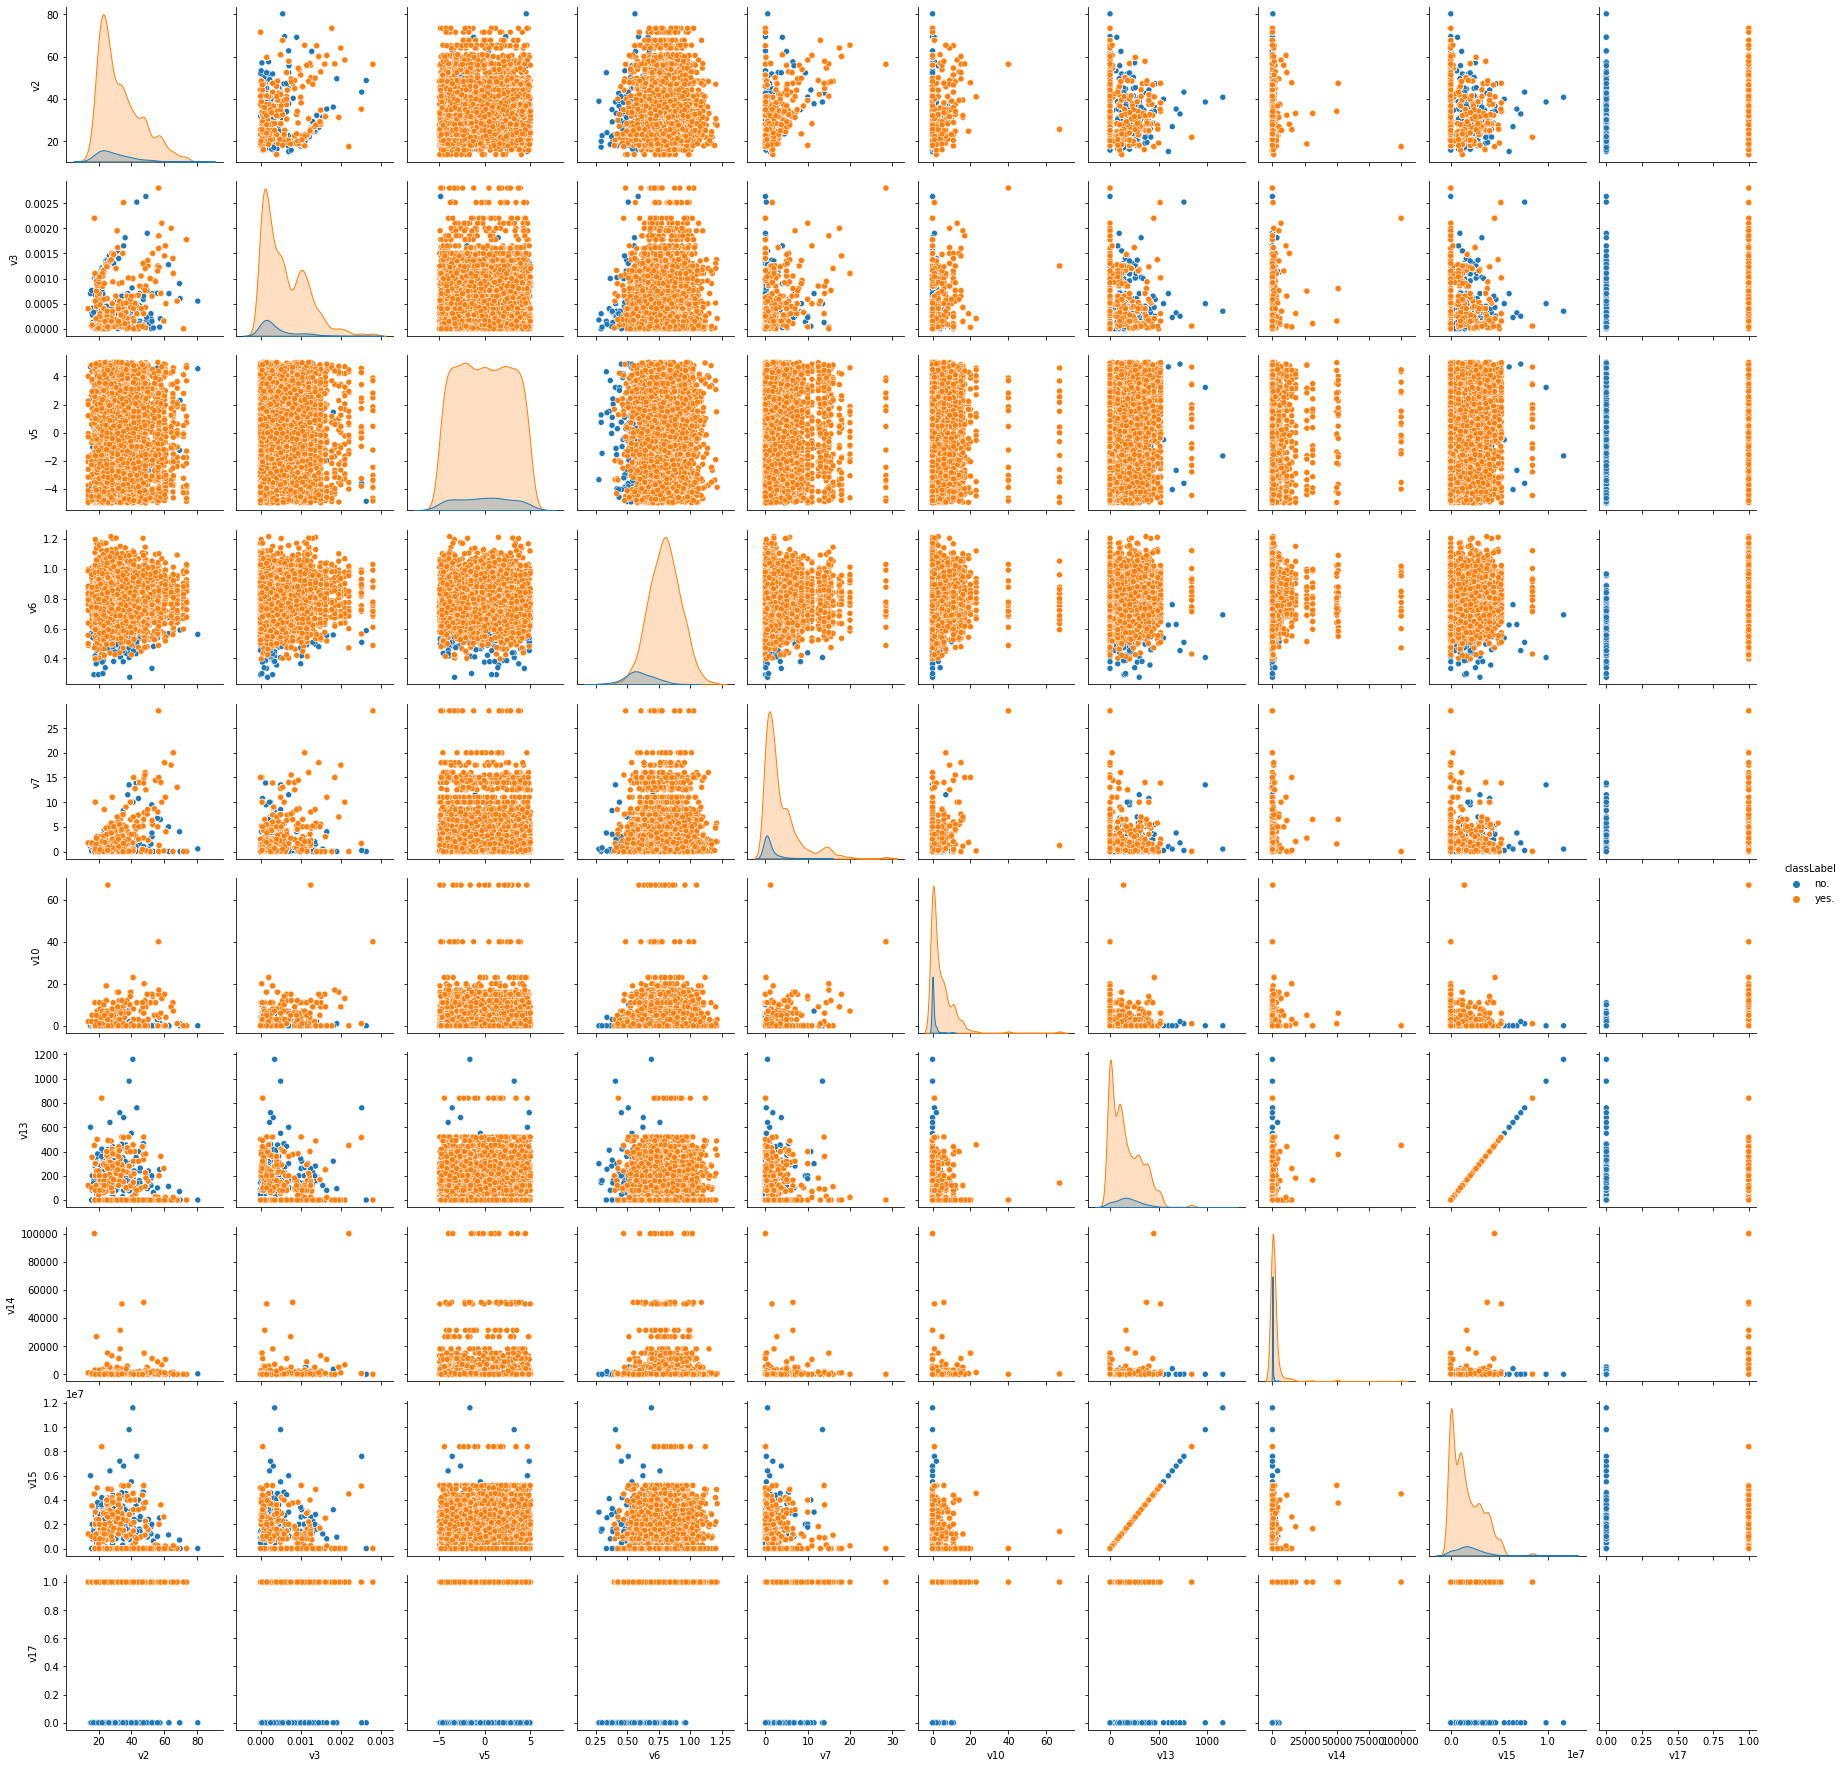

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(train, hue="classLabel")

In [ ]:
def one_hot(dfin):
  # dfin = pd.DataFrame(dfin, columns= COLS )
  df = pd.get_dummies(dfin
                 , columns= ['v1','v4','v8','v9','v11','v12','classLabel']
                 , dummy_na = False
                 , drop_first=False) # false as other values might be in test set or later
  return df

In [ ]:
train_ohe = one_hot(train)
train_ohe.sample(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v15,v16,v17,v1_a,v1_b,v4_l,v4_u,v4_y,v8_f,v8_t,v9_f,v9_t,v11_f,v11_t,v12_g,v12_p,v12_s,classLabel_no.,classLabel_yes.
319,23.25,0.000150,3.500941,0.585072,2.375,3,0.0,582,0.0,NaN,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,0,1
3117,NaN,0.001050,-1.238502,0.898092,6.500,0,0.0,0,0.0,f,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1
1957,22.92,0.001159,-0.929122,0.863460,0.040,0,80.0,1349,800000.0,NaN,1,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1


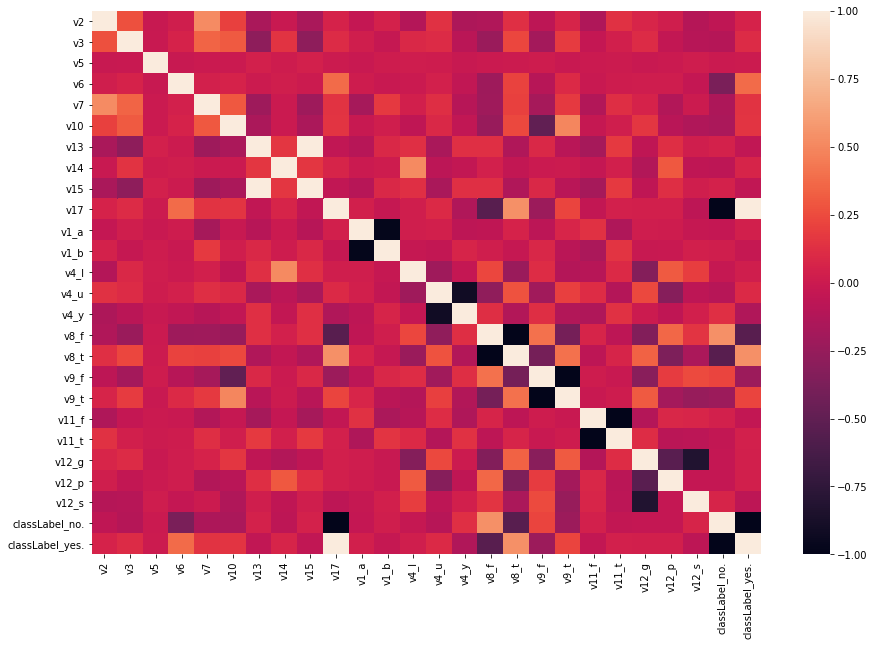

In [ ]:
corr = train_ohe.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr)
plt.show()

It is confirmed that V17 is correlated with the target variable. In fact V17 is the target variable.

In [ ]:
sum( train_ohe['v17'] != train_ohe['classLabel_yes.'])
#confirmed

0

## Is v17 equal to classLabel in test??
- **It is true for training only, but not for test**

In [ ]:
test_ohe = one_hot(test)
test_ohe.sample(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v15,v16,v17,v1_a,v1_b,v4_u,v4_y,v8_f,v8_t,v9_f,v9_t,v11_f,v11_t,v12_g,v12_o,v12_p,v12_s,classLabel_no.,classLabel_yes.
102,26.08,0.000866,-2.477355,0.612897,1.415,0,160.0,150,1600000.0,f,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1
95,24.58,0.000125,3.045797,0.477263,0.250,0,110.0,0,1100000.0,NaN,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0
27,34.42,0.000133,4.517812,0.525066,0.125,0,440.0,4500,4400000.0,NaN,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0


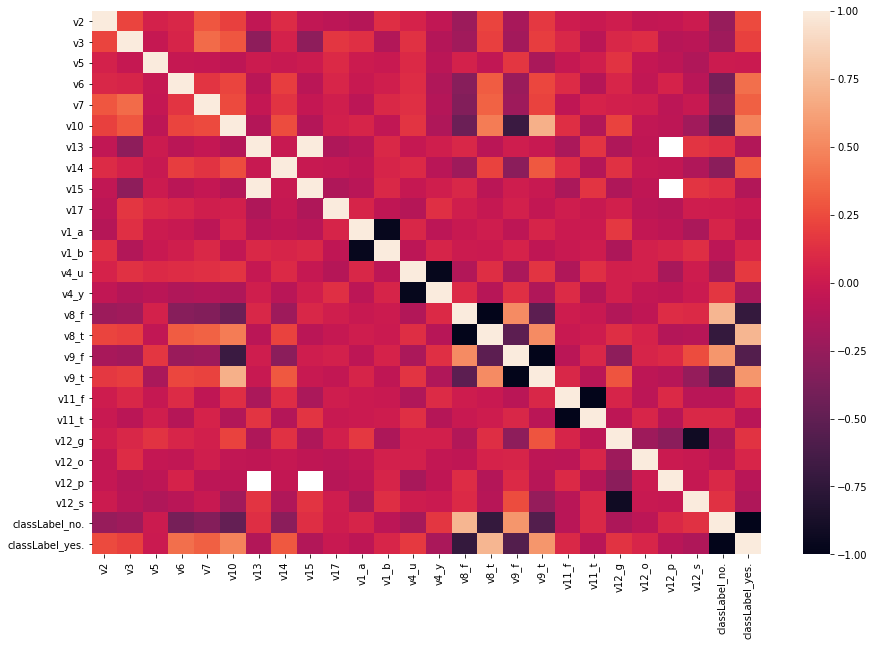

In [ ]:
corr = test_ohe.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr)
plt.show()

In [ ]:
sum( test_ohe['v17'] != test_ohe['classLabel_no.']),  sum( test_ohe['v17'] != test_ohe['classLabel_yes.'])

(99, 101)

# If v17 being equal to the classLabel is not a mistake, than we do not need to create any model. v17 is the answer
* v13 and v15 are highly correlated too. One of them can be deleted.
* v12_p is correlated to both v13 and v15.

- Try deleting v12_p, v13 and v17. We will be left with 20 variables.
- In test set, v17 is not equal to the labels

# Trying again after removing  3 columns
- Run Kers-DNN with weights for classes
- Try PCA on the initial data after one hot encoding.



# PCA-RandomForest
- **TODO: PCA -SVC**

In [ ]:
label_diction = { 'no.': 0 , 'yes.':1, 'yes':1, 'no':0}
def load_labels(inputCsv):
  return pd.read_csv( inputCsv , delimiter=';', decimal=','
  )['classLabel'].str.lower().replace(to_replace= label_diction)

In [ ]:
 def load_into_dataframe(inputCsv) :
  df = pd.read_csv( inputCsv , delimiter=';', decimal=',')  # load as dataframe
  df = df.drop(columns= ['v16','classLabel'])  #drop the column that has 50% training
  global COLS
  COLS = df.columns
  return df

Deleting the 3 columns found after correlation analysis

In [ ]:
columns_commmon = {'v10', 'v11_f', 'v11_t', 'v12_g', 'v12_p', 'v12_s',
 'v13', 'v14', 'v15', 'v17', 'v1_a', 'v1_b', 'v2', 'v3', 'v4_u', 'v4_y',
 'v5', 'v6', 'v7', 'v8_f',  'v8_t', 'v9_f', 'v9_t'} - {'v12_p','v13','v17'}
# set(X_train.columns).intersection( set(X_test.columns) )

In [ ]:
def one_hot_encode(dfin):
  # dfin = pd.DataFrame(dfin, columns= COLS )
  df = pd.get_dummies(dfin
                 , columns= ['v1','v4','v8','v9','v11','v12']
                 , dummy_na = False
                 , drop_first=False) # false as other values might be in test set or later
  return df[[c  for c in columns_commmon]]

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
# class_weight ={}

In [ ]:
pre_pipe = Pipeline([
                  (  'load_into_df', FunctionTransformer( load_into_dataframe )  )                     
                    , ( 'one_hot_enc' ,  FunctionTransformer( one_hot_encode ) )     
                    , ('imputer', KNNImputer(n_neighbors=3) )     
                    , ('scaler', StandardScaler()  )  
                     ])

pipe = Pipeline( [
                     ('pca', PCA(n_components= 8) )    
                    ,   ('rfc', RandomForestClassifier(class_weight='balanced_subsample',
                                                       max_depth=7 ) ) 
                    ])

In [ ]:
pfit = pre_pipe.fit( TRAIN_LOCATION )
X_train = pfit.transform( TRAIN_LOCATION)
X_test = pfit.transform( TEST_LOCATION )

In [ ]:
X_train.shape, X_test.shape

((3700, 20), (200, 20))

In [ ]:
y_train = load_labels(TRAIN_LOCATION)
y_test = load_labels(TEST_LOCATION)

In [ ]:
pipe = pipe.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'pca__n_components': [5, 8,10,15] , 'rfc__max_depth': [ 7, 8, 12, 15]}
clf = GridSearchCV(pipe, param_grid= parameters
                   , cv=4
                   ,scoring = 'f1'
                   ,refit = True)
clf = clf.fit(X_train,y_train)

In [ ]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rfc',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced_subsample',
                                        criterion='gini', max_depth=15,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        o

In [ ]:
clf.score(X_test, y_test)

0.8017621145374448

# In this case the manual hyperparamers gave better result than GridSearch
- Sticking with the pipe classifier rather than the gridsearch classifier

In [ ]:
pipe.score(X_test, y_test)

0.815

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, pipe.predict(X_test))

0.8262910798122065

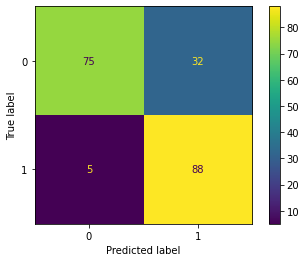

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe, X_test,y_test)

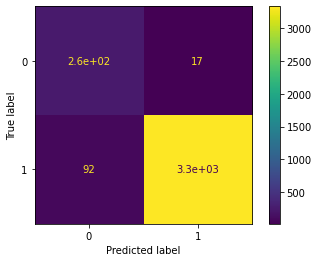

In [ ]:
plot_confusion_matrix(pipe, X_train,y_train)

# Try DNN

In [ ]:
 tf.math.exp(-0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.60653067>

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.5)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('dense1',  list(range(8,20,2))  ),
      activation='relu'))
  
  model.add(keras.layers.Dropout(0.5))
  
  model.add(keras.layers.Dense(
      hp.Choice('dense2',  list(range(4,10,2))  ),
      activation='tanh'))
  
  model.add(keras.layers.Dropout(0.5))
  
  model.add(keras.layers.Dense(
      hp.Choice('dense3',  list(range(2,6,1))  ),
      activation='tanh'))
  
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy'
  , metrics = [f1_m] # keras.metrics.AUC(), 'accuracy'
   , optimizer= 'adam')
  return model

In [ ]:
# Need to remove this folder as it is preventing when I run second time
!rm -rf '/content/data/untitled_project'
!rm -rf '/content/data/untitled_project'

In [ ]:
tuner = kt.RandomSearch(
            build_model,
            objective=   kt.Objective("f1_m", direction="max"),
            max_trials=50,
            directory = '/content/data')

In [ ]:
from sklearn.model_selection import train_test_split
X_tr,  X_val, y_tr , y_val = train_test_split( X_train, y_train, test_size= 0.2
                                              , stratify= y_train, random_state=5)

In [ ]:
tuner.search(X_tr, y_tr, epochs=5 
             , validation_data = (X_val, y_val) 
            , class_weight = {0: 10. ,  1: 1}) 

Trial 50 Complete [00h 00m 02s]
f1_m: 0.8568470478057861

Best f1_m So Far: 0.9138983488082886
Total elapsed time: 00h 01m 58s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# tuner.results_summary()

In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model.
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.5728 - f1_m: 0.6367


[0.5727638006210327, 0.6367488503456116]

In [ ]:
best_model.build(input_shape=[None, 20])
print( best_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                294       
_________________________________________________________________
dropout (Dropout)            (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [ ]:
best_model.fit(X_train, y_train, epochs=55 
            , class_weight = {0: 10 ,  1: 1} 
            , callbacks=[callback])  

Epoch 1/55
116/116 [==============================] - 1s 2ms/step - loss: 0.9964 - f1_m: 0.9201
Epoch 2/55
116/116 [==============================] - 0s 1ms/step - loss: 0.9537 - f1_m: 0.9156
Epoch 3/55
116/116 [==============================] - 0s 1ms/step - loss: 0.9287 - f1_m: 0.9162
Epoch 4/55
116/116 [==============================] - 0s 1ms/step - loss: 0.8827 - f1_m: 0.9283
Epoch 5/55
116/116 [==============================] - 0s 1ms/step - loss: 0.8826 - f1_m: 0.9267
Epoch 6/55
116/116 [==============================] - 0s 2ms/step - loss: 0.8674 - f1_m: 0.9291
Epoch 7/55
116/116 [==============================] - 0s 2ms/step - loss: 0.8486 - f1_m: 0.9337
Epoch 8/55
116/116 [==============================] - 0s 1ms/step - loss: 0.8480 - f1_m: 0.9269
Epoch 9/55
116/116 [==============================] - 0s 1ms/step - loss: 0.8361 - f1_m: 0.9329
Epoch 10/55
116/116 [==============================] - 0s 1ms/step - loss: 0.7969 - f1_m: 0.9355
Epoch 11/55
116/116 [==================

In [ ]:
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.4236 - f1_m: 0.6469


[0.4236091673374176, 0.6468841433525085]

# Final Verdict
- **PCA followed by Random Forest gave the best result**
```
pipe = Pipeline( [
                     ('pca', PCA(n_components= 8) )    
                    ,   ('rfc', RandomForestClassifier(class_weight='balanced_subsample',
                                                       max_depth=7 ) ) 
                    ])
```